## Construcción de un modelo CNN con muy pocos datos
### Parte 1 -  análisis del modelo entrenado

In [1]:
# Adaptado de:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [2]:
import cv2 # pip install opencv-python

from keras.models import Sequential, load_model, Model, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers, models
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

Using TensorFlow backend.


In [3]:
# dimensions of our images.
img_width, img_height = 150, 150
#img_width, img_height = 20, 20

In [4]:
aux = '_' + str(img_width) + 'x' + str(img_height) + '.npy'
print('leyendo mi_Xtr'+aux+'...')
Xtr = np.load('mi_Xtr'+aux)
print('leyendo mi_Xva'+aux+'...')
Xva = np.load('mi_Xva'+aux)
print('leyendo mi_Xte'+aux+'...')
Xte = np.load('mi_Xte'+aux)
print('leyendo mi_ytr.npy, mi_yva.npy, mi_yte.npy ...')
ytr = np.load('mi_ytr.npy')
yva = np.load('mi_yva.npy')
yte = np.load('mi_yte.npy')

leyendo mi_Xtr_150x150.npy...
leyendo mi_Xva_150x150.npy...
leyendo mi_Xte_150x150.npy...
leyendo mi_ytr.npy, mi_yva.npy, mi_yte.npy ...


In [5]:
print(Xtr.shape)
print(Xva.shape)
print(Xte.shape)

(2000, 150, 150, 3)
(802, 150, 150, 3)
(2002, 150, 150, 3)


In [6]:
input_shape = Xtr.shape[1:]

## Modelo base

In [7]:
CHEQUEA_LOGISTIC_REGRESSION = False # Modelo base. Cuidado que si el ordenador no es potente
                                    # puede dejarlo colgado

if CHEQUEA_LOGISTIC_REGRESSION:
    Xtr2 = np.zeros((len(Xtr),
                     np.shape(Xtr)[1]*np.shape(Xtr)[2]*np.shape(Xtr)[3]))
    for i in range(np.shape(Xtr)[0]):
        Xtr2[i] = Xtr[i].flatten()
    Xte2 = np.zeros((np.shape(Xte)[0],
                     np.shape(Xte)[1]*np.shape(Xte)[2]*np.shape(Xte)[3]))
    for i in range(np.shape(Xte)[0]):
        Xte2[i] = Xte[i].flatten()
    
    print("Xtr2 shape:", np.shape(Xtr2))
    print("Xtr shape:   ", np.shape(Xtr))
    print("Xte2 shape: ", np.shape(Xte2))
    print("Xte shape:   ", np.shape(Xte))

In [8]:
if CHEQUEA_LOGISTIC_REGRESSION:
    from sklearn.linear_model import LogisticRegression
    model2 = LogisticRegression()
    model2.fit(Xtr2, ytr)

In [9]:
if CHEQUEA_LOGISTIC_REGRESSION:
    print("score de regresion logistica en training: ", model2.score(Xtr2, ytr))
    print("score de regresion logistica en test    : ", model2.score(Xte2, yte))

## CNN

In [10]:
model = load_model('model_current_best_parte1.h5')

In [11]:
model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

## Resultados obtenidos

In [12]:
score_tr = model.evaluate(Xtr, ytr, verbose=1)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])

score_val = model.evaluate(Xva, yva, verbose=1)
print('Val loss    :', score_val[0])
print('Val accuracy:', score_val[1])

score_te = model.evaluate(Xte, yte, verbose=1)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

2000/2000 [==============================] - 141s 70ms/step
Train loss    : 0.023530910490080714
Train accuracy: 0.9985
802/802 [==============================] - 60s 75ms/step
Val loss    : 1.3213744525590962
Val accuracy: 0.773067331670823
2002/2002 [==============================] - 155s 77ms/step
Test loss     : 1.4067456253044135
Test accuracy : 0.7442557442557443


In [13]:
y_pred_proba = model.predict(Xte, verbose=1)
y_pred = np.round(y_pred_proba)
print('')
print(classification_report(yte, y_pred))

2002/2002 [==============================] - 159s 79ms/step

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1002
           1       0.74      0.76      0.75      1000

   micro avg       0.74      0.74      0.74      2002
   macro avg       0.74      0.74      0.74      2002
weighted avg       0.74      0.74      0.74      2002



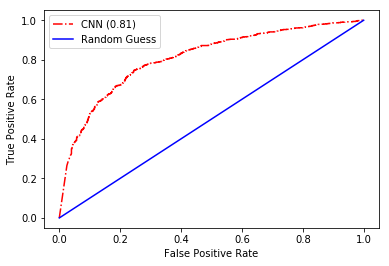

In [14]:
fpr, tpr, thresholds = roc_curve(yte, y_pred_proba)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

## Visualización del funcionamiento de la red

In [15]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(10,)
shape of weights[0]:  (3, 3, 3, 32)
shape of weights[1]:  (32,)
shape of weights[2]:  (3, 3, 32, 32)
shape of weights[3]:  (32,)
shape of weights[4]:  (3, 3, 32, 64)
shape of weights[5]:  (64,)
shape of weights[6]:  (18496, 128)
shape of weights[7]:  (128,)
shape of weights[8]:  (128, 1)
shape of weights[9]:  (1,)


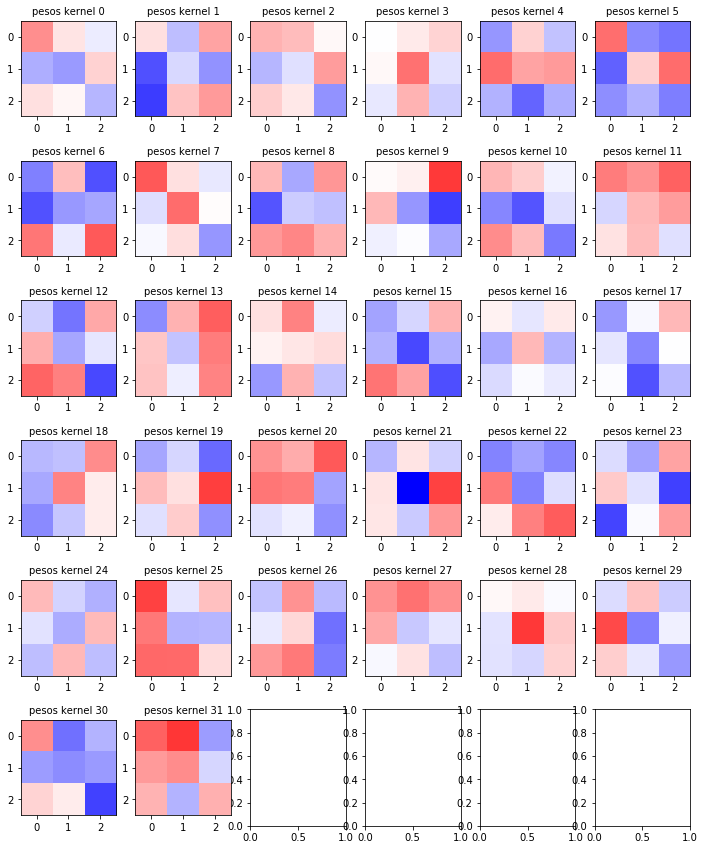

In [16]:
# kernels de la primera capa convolucional
ncapa = 0

nfilters = weights[ncapa].shape[3]
lado = int(np.ceil(np.sqrt(nfilters)))
plt.subplots(lado,lado,figsize = (12, 15))

ma = abs(weights[ncapa]).max()

for i in range(nfilters):
    kernel = weights[ncapa][:,:,2,i]
    plt.subplot(lado,lado,i+1)
    plt.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    plt.title('pesos kernel %d' % i, fontsize=10)

### Visualización de las salidas de una sola capa

In [17]:
# salida de una sola capa
ncapa = 0
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa].output)
intermediate_layer_model.summary()
#SVG(model_to_dot(intermediate_layer_model,show_shapes=True).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


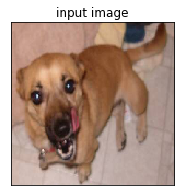

Salidas capa conv2d_1 (1, 148, 148, 32)


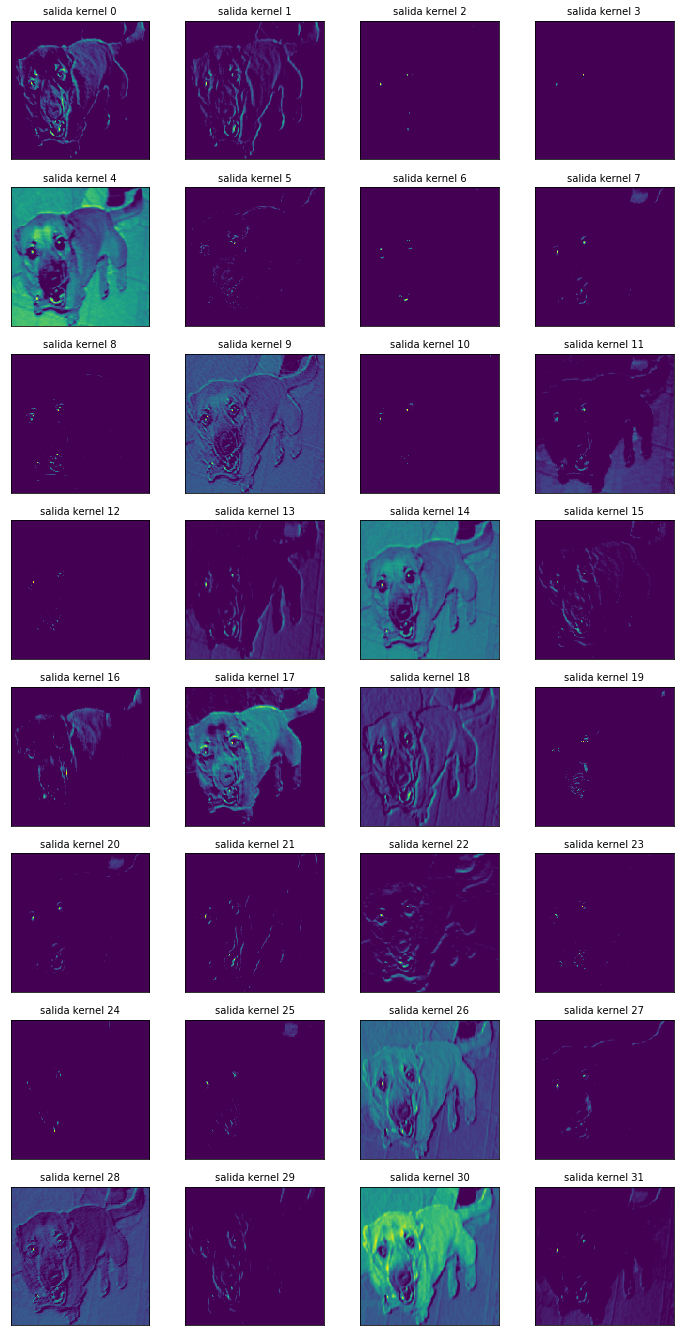

In [18]:
imagen = Xte[101]
imagen = Xte[150]

aux = imagen.reshape((1,) + imagen.shape)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)
plt.show()

### Visualización de las salidas de varias capas

In [24]:
# Now we extract the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(Xte[150:151])

/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


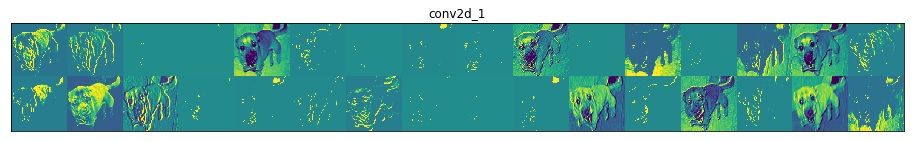

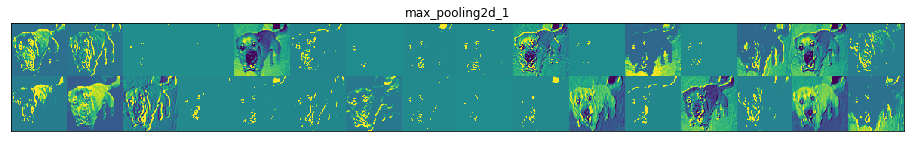

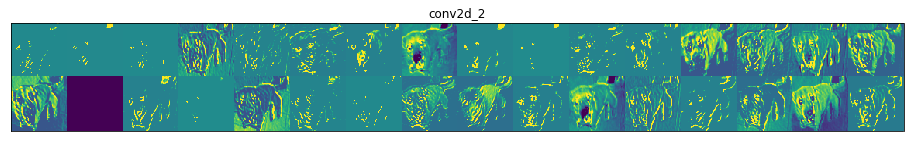

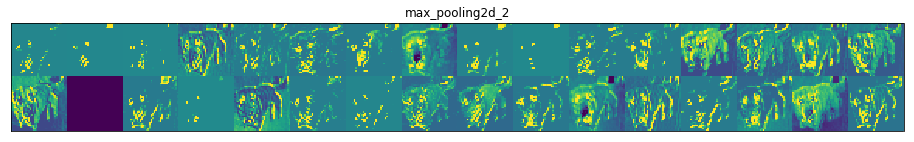

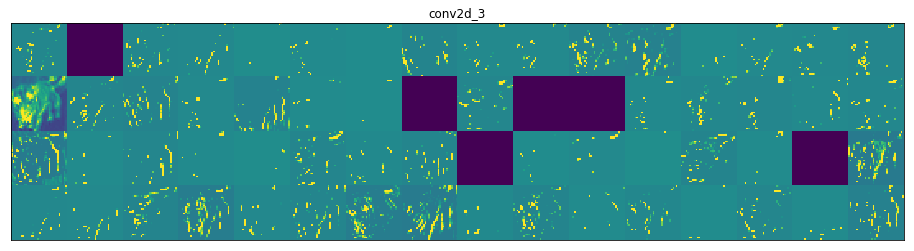

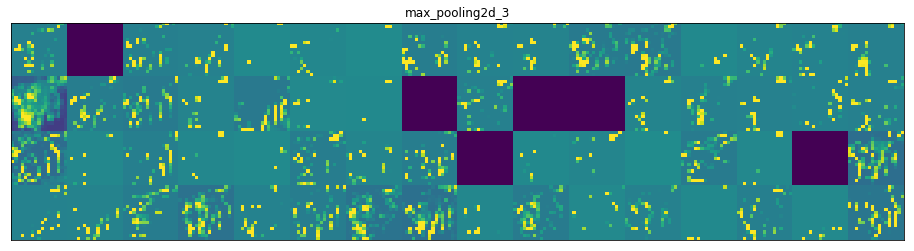

In [25]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### ¿A qué partes de la imagen de entrada es más sensible la salida de la red?

In [26]:
def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer

In [27]:
def show_heatmap(model, im):
    imag = np.reshape(im, (1, im.shape[0], im.shape[1], im.shape[2]))
    
    # This is the "dog" entry in the prediction vector
    output = model.output[:, 0]
    
    # The is the output feature map of the last convolutional layer
    #last_conv_layer = model.layers[4]
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "dog" class with regard to
    # the output feature map of last convolutional layer
    grads = K.gradients(output, last_conv_layer.output)[0]
    
    # This is a vector of shape (64,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of the last convolutional layer
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image
    pooled_grads_value, conv_layer_output_value = iterate([imag])
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the output of the model
    for i in range(conv_layer_output_value.shape[2]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    #print(np.max(heatmap))
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()
        
    img = imag[0]
    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        
    # We apply the heatmap to the original image    
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)/255
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + 0.6*img
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img, vmin=0, vmax=1)
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1)
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1)
    plt.show()
    print("Probabilidad clase perro:", model.predict(imag)[0][0])
    return heatmap, superimposed_img

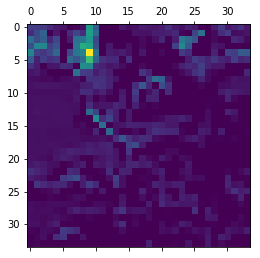

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


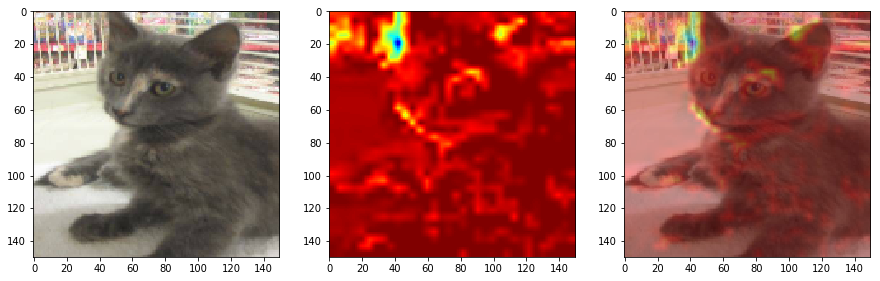

Probabilidad clase perro: 0.30777374


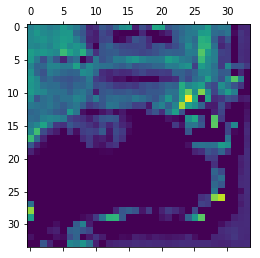

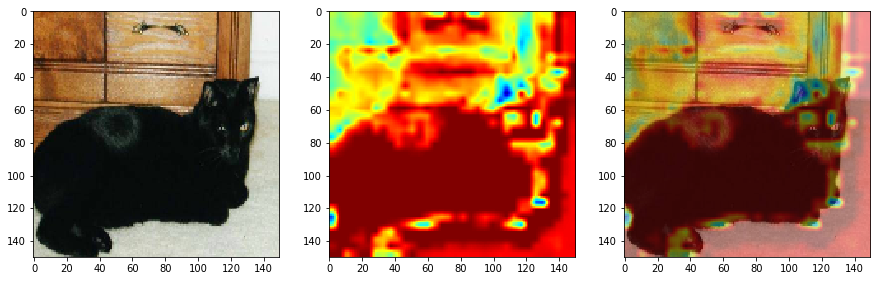

Probabilidad clase perro: 3.191044e-09


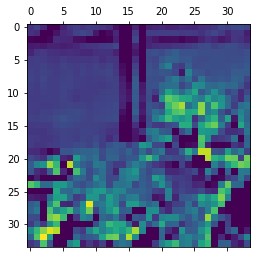

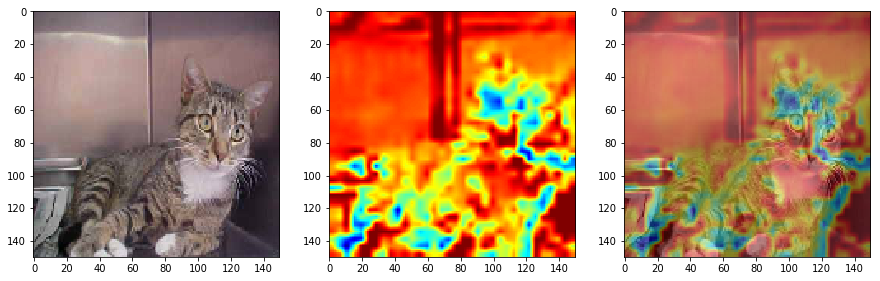

Probabilidad clase perro: 0.00029020346


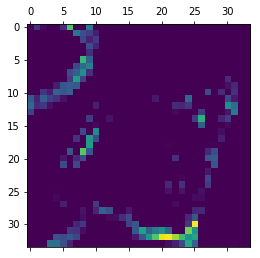

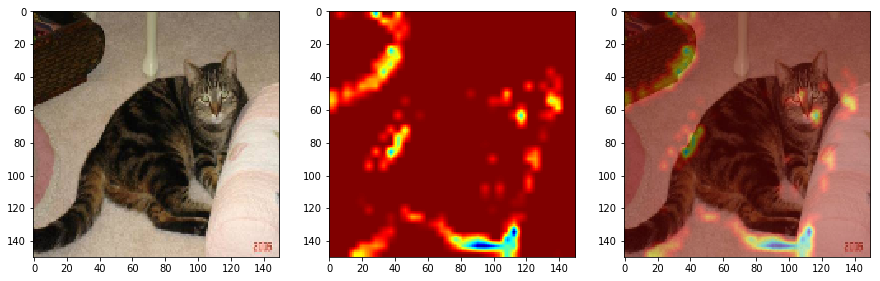

Probabilidad clase perro: 0.72856706


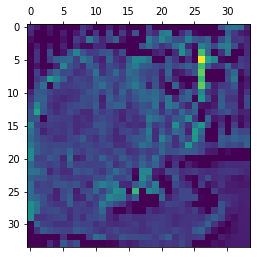

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


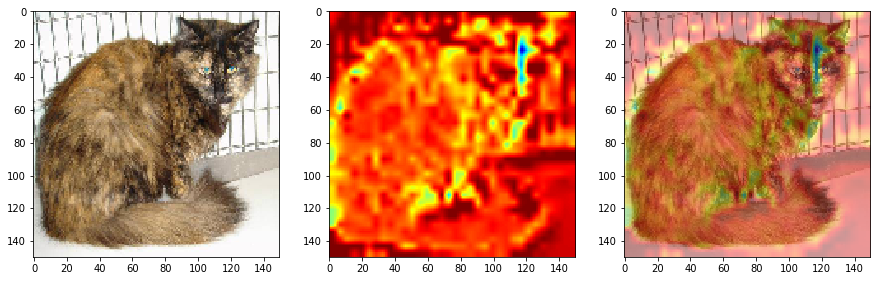

Probabilidad clase perro: 0.17217322


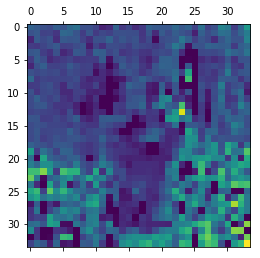

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


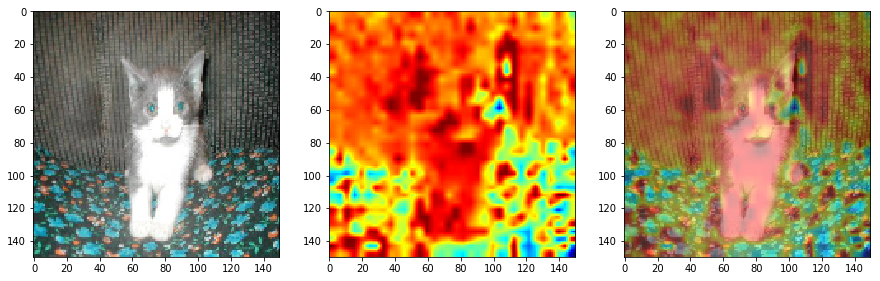

Probabilidad clase perro: 0.00023579721


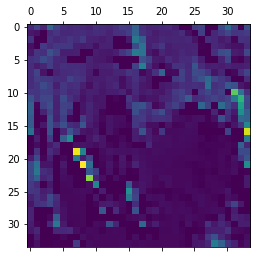

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


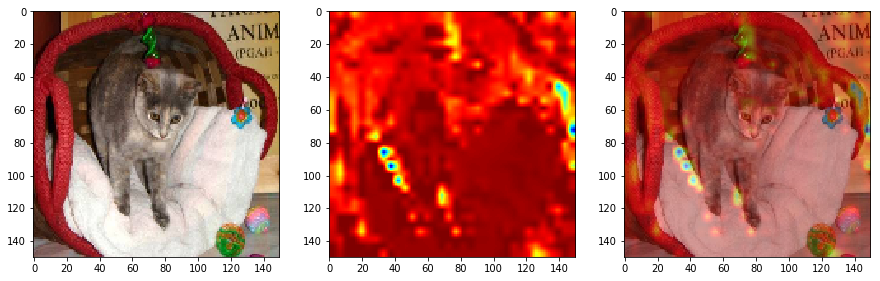

Probabilidad clase perro: 0.44178134


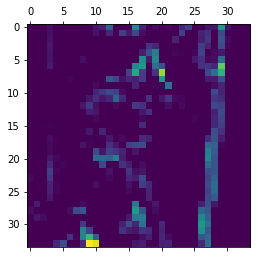

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


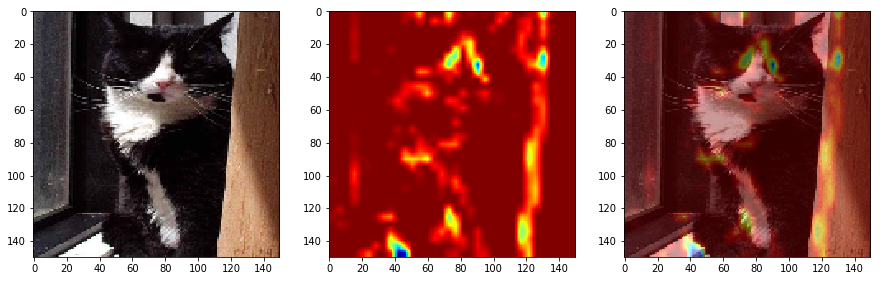

Probabilidad clase perro: 0.99998486


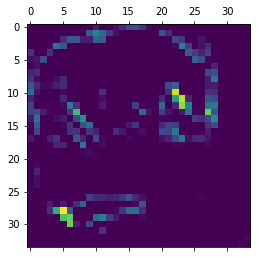

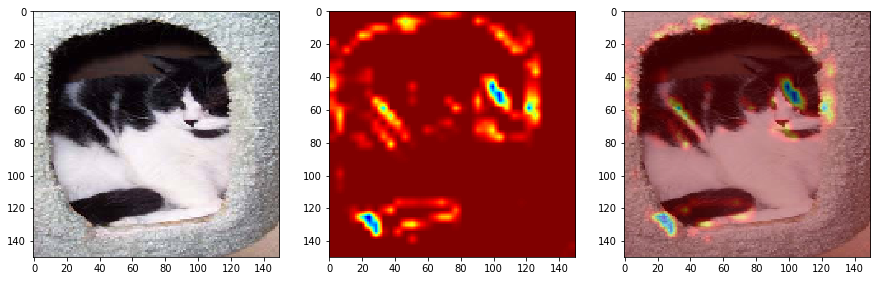

Probabilidad clase perro: 0.9999987


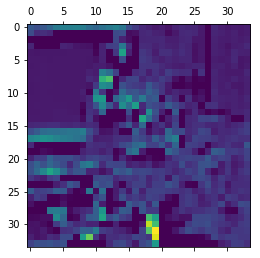

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


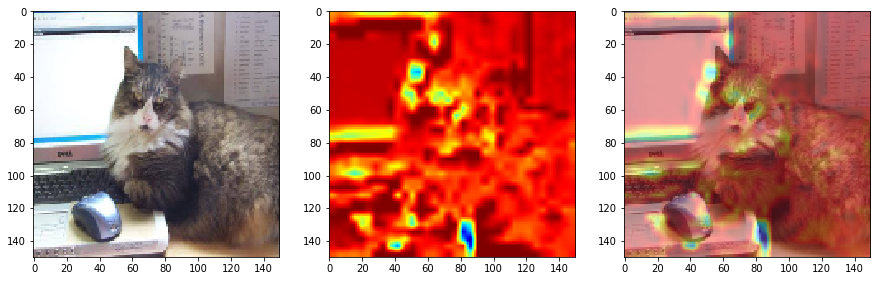

Probabilidad clase perro: 0.0015567822


In [28]:
ind = 1051 # 1005, 1050
for i in range(ind, ind+10):
    heat_map, superimposed_img = show_heatmap(model, Xte[i])
    #print(heat_map.min(), heat_map.max(), superimposed_img.min(), superimposed_img.max())

# Save the image
#cv2.imwrite('dog.jpg', superimposed_img)